# Smile Detection using Autoencoder for Anomaly Detection
## Dataset: LFW (Labeled Faces in the Wild)
### Approach: Train on SMILING faces only, detect NON-SMILING as anomalies

## Celda 1: Importar librerías necesarias

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

%matplotlib inline

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.9.1+cpu
CUDA available: False


## Celda 2: Definir el Dataset personalizado (cargar desde dataset.py)

In [2]:
# Importar el dataset que ya creamos
from dataset import LFWDataset

# Configurar rutas ABSOLUTAS - CORREGIDO: Agregar /faces
FACES_FOLDER = r'C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\lfwcrop_color\faces'
SMILE_FILE = r'C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\SMILE_list.txt'
NON_SMILE_FILE = r'C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\NON-SMILE_list.txt'

# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar a 64x64 para reducir complejidad
    transforms.ToTensor(),
])

print("Dataset class imported successfully!")
print(f"FACES_FOLDER: {FACES_FOLDER}")
print(f"SMILE_FILE: {SMILE_FILE}")
print(f"NON_SMILE_FILE: {NON_SMILE_FILE}")

Dataset class imported successfully!
FACES_FOLDER: C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\lfwcrop_color\faces
SMILE_FILE: C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\SMILE_list.txt
NON_SMILE_FILE: C:\Users\USER\Documents\ITESM\Neural Networks\Smile Detection Model\NON-SMILE_list.txt


## Celda 3: Cargar el dataset completo y dividir en clases

In [3]:
# Cargar el dataset completo
full_dataset = LFWDataset(
    faces_folder=FACES_FOLDER,
    smiling_labels_file=SMILE_FILE,
    non_smiling_labels_file=NON_SMILE_FILE,
    transform=transform
)

print(f"Total images in dataset: {len(full_dataset)}")

# Separar índices de smiling y non-smiling
smiling_indices = [i for i, label in enumerate(full_dataset.labels) if label == 1]
non_smiling_indices = [i for i, label in enumerate(full_dataset.labels) if label == 0]

print(f"Smiling faces: {len(smiling_indices)}")
print(f"Non-smiling faces: {len(non_smiling_indices)}")

# Crear subsets
smiling_dataset = Subset(full_dataset, smiling_indices)
non_smiling_dataset = Subset(full_dataset, non_smiling_indices)

Total images in dataset: 1203
Smiling faces: 600
Non-smiling faces: 603


## Celda 4: Visualizar algunas imágenes del dataset

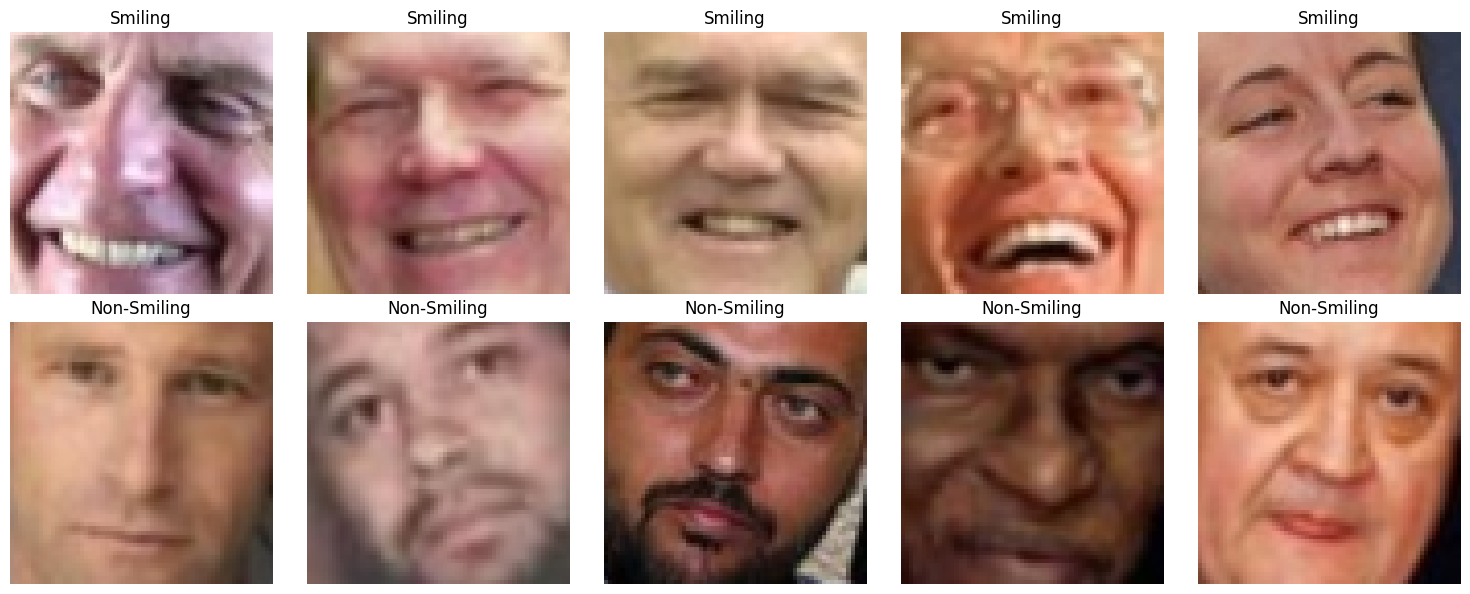

In [4]:
# Visualizar imágenes de ejemplo
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Mostrar 5 caras con sonrisa
for i in range(5):
    img, label = smiling_dataset[i]
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].set_title('Smiling')
    axes[0, i].axis('off')

# Mostrar 5 caras sin sonrisa
for i in range(5):
    img, label = non_smiling_dataset[i]
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title('Non-Smiling')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Celda 5: Dividir el dataset de SMILING en train/validation

In [21]:
# IMPORTANTE: Solo usaremos SMILING faces para entrenar (anomaly detection)
# El autoencoder aprenderá a reconstruir solo caras con sonrisa

# Dividir smiling dataset en train y validation
val_split = 0.15
val_size = int(val_split * len(smiling_dataset))
train_size = len(smiling_dataset) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(
    smiling_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training set size (SMILING only): {len(train_dataset)}")
print(f"Validation set size (SMILING only): {len(val_dataset)}")
print(f"Test set will include both SMILING and NON-SMILING for anomaly detection")

Training set size (SMILING only): 510
Validation set size (SMILING only): 90
Test set will include both SMILING and NON-SMILING for anomaly detection


## Celda 6: Crear DataLoaders

In [6]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Para testing usaremos ambas clases
test_loader_smiling = DataLoader(
    val_dataset,  # Usamos un subset de smiling para test
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader_non_smiling = DataLoader(
    non_smiling_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batches: {len(val_loader)}")
print(f"Test loader (smiling) batches: {len(test_loader_smiling)}")
print(f"Test loader (non-smiling) batches: {len(test_loader_non_smiling)}")

Train loader batches: 16
Val loader batches: 3
Test loader (smiling) batches: 3
Test loader (non-smiling) batches: 19


## Celda 7: Definir la arquitectura del Autoencoder Convolucional

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        # Input: 3 x 64 x 64
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 256 x 4 x 4
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 128 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # 3 x 64 x 64
            nn.Sigmoid()  # Valores entre 0 y 1
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Crear el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Using device: cpu

Model architecture:
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

Total parameters: 77

## Celda 8: Definir funciones de entrenamiento y evaluación

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Entrenar por una época"""
    model.train()
    train_loss = 0.0
    
    for batch_data, _ in train_loader:  # No usamos las etiquetas
        batch_data = batch_data.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    return train_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """Validar el modelo"""
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_data, _ in val_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_data)
            val_loss += loss.item()
    
    return val_loss / len(val_loader)


def compute_reconstruction_error(model, data_loader, device):
    """Calcular el error de reconstrucción para detección de anomalías"""
    model.eval()
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data)
            
            # Calcular MSE por imagen
            batch_errors = torch.mean((batch_data - outputs) ** 2, dim=(1, 2, 3))
            reconstruction_errors.extend(batch_errors.cpu().numpy())
    
    return np.array(reconstruction_errors)

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


## Celda 9: Configurar y entrenar el modelo

In [9]:
# Hiperparámetros
EPOCHS = 50
LEARNING_RATE = 0.001

# Optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Listas para guardar el historial
train_losses = []
val_losses = []

print(f"Starting training for {EPOCHS} epochs...")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}\n")

# Training loop
for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("\nTraining completed!")

Starting training for 50 epochs...
Learning rate: 0.001
Batch size: 32



Training Progress:  10%|█         | 5/50 [00:36<05:26,  7.25s/it]

Epoch [5/50], Train Loss: 0.0151, Val Loss: 0.0128


Training Progress:  20%|██        | 10/50 [01:13<04:57,  7.44s/it]

Epoch [10/50], Train Loss: 0.0085, Val Loss: 0.0081


Training Progress:  30%|███       | 15/50 [01:51<04:23,  7.54s/it]

Epoch [15/50], Train Loss: 0.0073, Val Loss: 0.0069


Training Progress:  40%|████      | 20/50 [02:28<03:42,  7.41s/it]

Epoch [20/50], Train Loss: 0.0061, Val Loss: 0.0058


Training Progress:  50%|█████     | 25/50 [03:06<03:09,  7.59s/it]

Epoch [25/50], Train Loss: 0.0065, Val Loss: 0.0055


Training Progress:  60%|██████    | 30/50 [03:45<02:37,  7.86s/it]

Epoch [30/50], Train Loss: 0.0057, Val Loss: 0.0050


Training Progress:  70%|███████   | 35/50 [04:34<02:37, 10.51s/it]

Epoch [35/50], Train Loss: 0.0041, Val Loss: 0.0040


Training Progress:  80%|████████  | 40/50 [05:16<01:24,  8.48s/it]

Epoch [40/50], Train Loss: 0.0038, Val Loss: 0.0037


Training Progress:  90%|█████████ | 45/50 [06:20<01:06, 13.33s/it]

Epoch [45/50], Train Loss: 0.0036, Val Loss: 0.0035


Training Progress: 100%|██████████| 50/50 [07:20<00:00,  8.81s/it]

Epoch [50/50], Train Loss: 0.0035, Val Loss: 0.0036

Training completed!


## Celda 10: Graficar el historial de entrenamiento

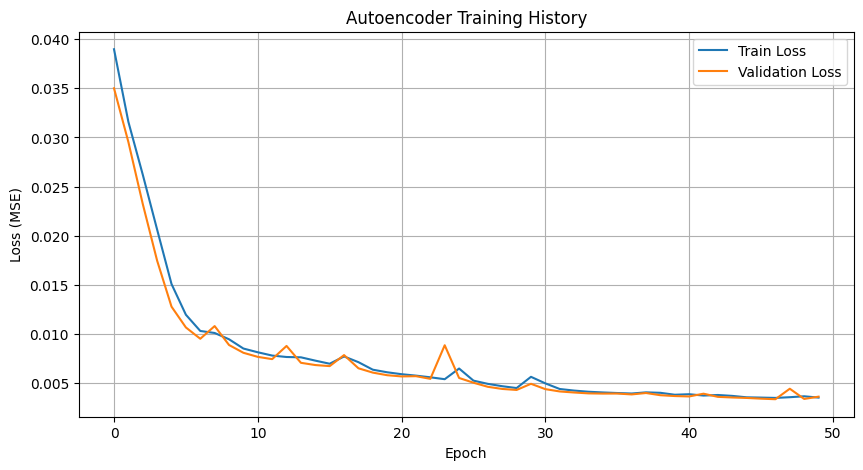

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Celda 11: Visualizar reconstrucciones en caras SMILING

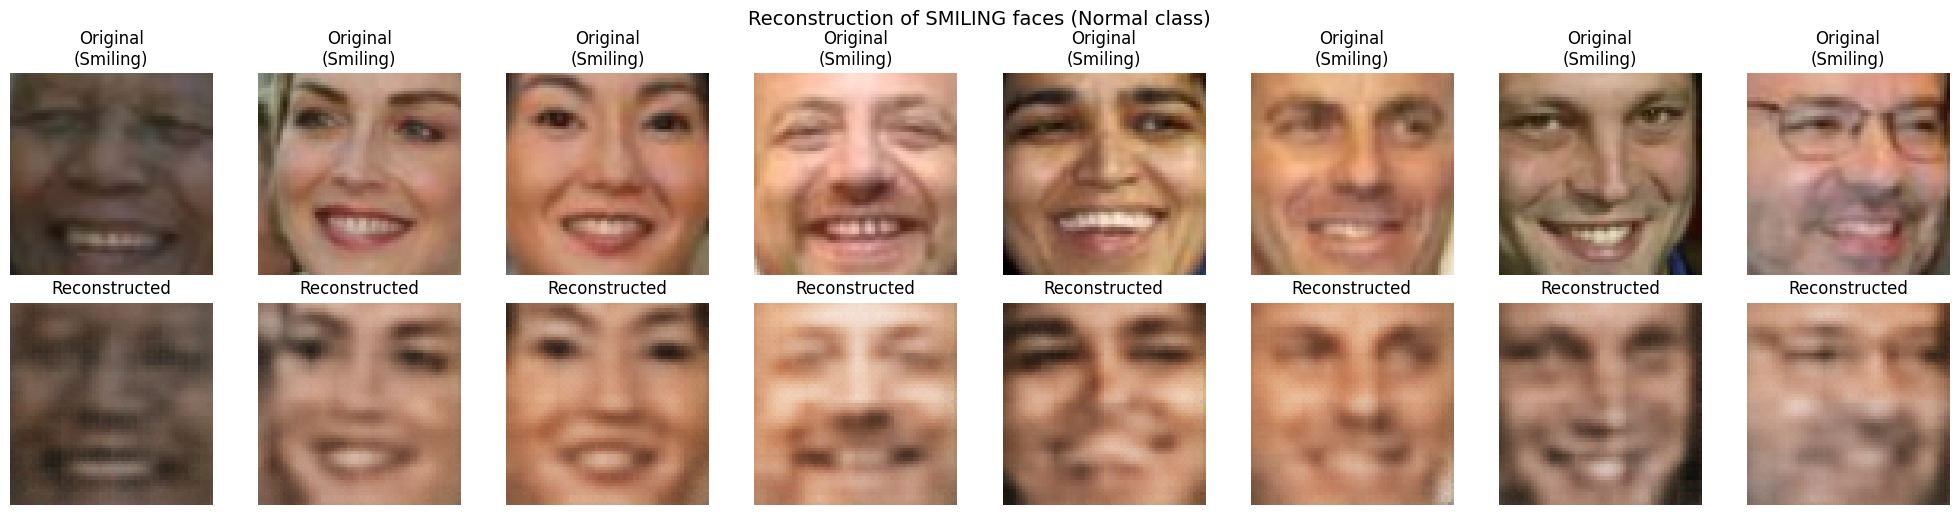

In [11]:
# Obtener algunas imágenes de validación
model.eval()
with torch.no_grad():
    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(device)
    reconstructed = model(sample_images)

# Visualizar
n_images = 8
fig, axes = plt.subplots(2, n_images, figsize=(20, 5))

for i in range(n_images):
    # Original
    axes[0, i].imshow(sample_images[i].cpu().permute(1, 2, 0))
    axes[0, i].set_title('Original\n(Smiling)')
    axes[0, i].axis('off')
    
    # Reconstruida
    axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0))
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle('Reconstruction of SMILING faces (Normal class)', y=1.02, fontsize=14)
plt.show()

## Celda 12: Visualizar reconstrucciones en caras NON-SMILING (Anomalías)

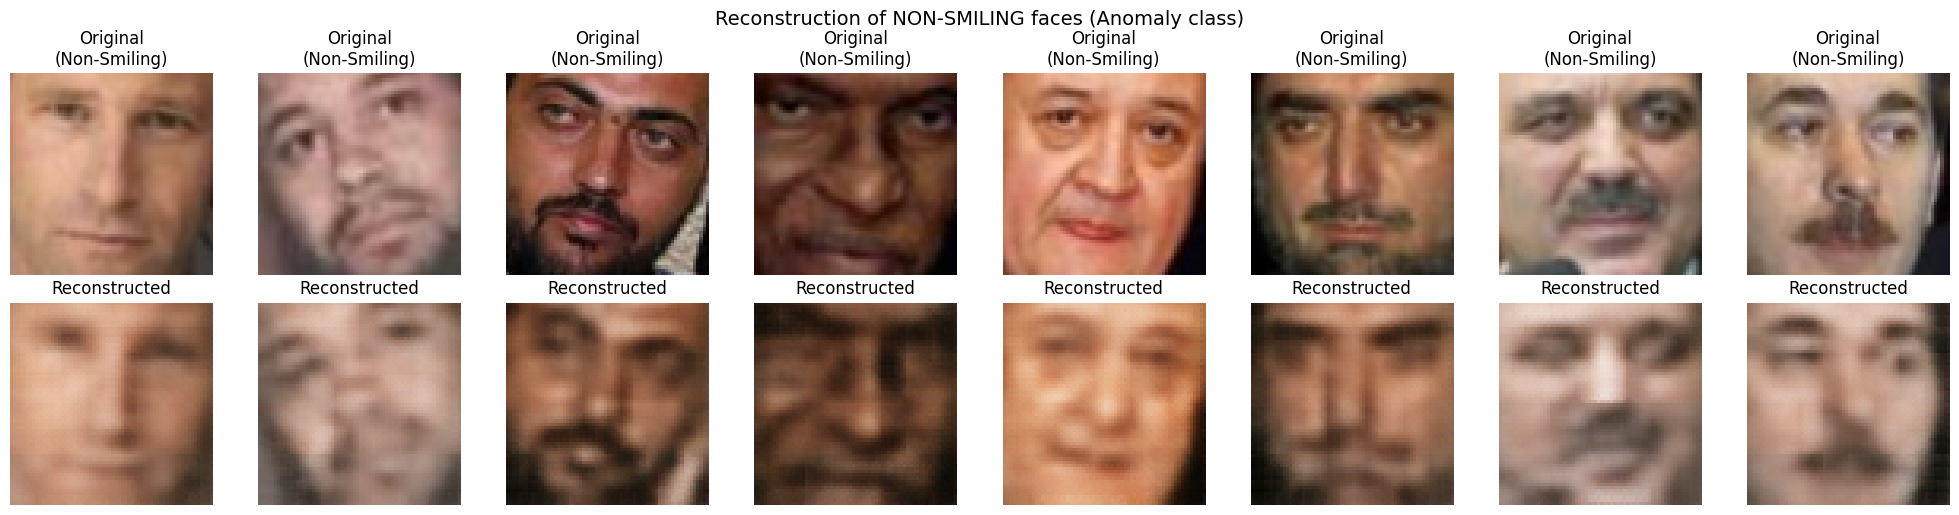

Notice: The reconstruction quality should be worse for non-smiling faces!


In [12]:
# Obtener imágenes NON-SMILING
model.eval()
with torch.no_grad():
    sample_non_smiling, _ = next(iter(test_loader_non_smiling))
    sample_non_smiling = sample_non_smiling.to(device)
    reconstructed_non_smiling = model(sample_non_smiling)

# Visualizar
n_images = 8
fig, axes = plt.subplots(2, n_images, figsize=(20, 5))

for i in range(n_images):
    # Original
    axes[0, i].imshow(sample_non_smiling[i].cpu().permute(1, 2, 0))
    axes[0, i].set_title('Original\n(Non-Smiling)')
    axes[0, i].axis('off')
    
    # Reconstruida (debería ser peor)
    axes[1, i].imshow(reconstructed_non_smiling[i].cpu().permute(1, 2, 0))
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle('Reconstruction of NON-SMILING faces (Anomaly class)', y=1.02, fontsize=14)
plt.show()

print("Notice: The reconstruction quality should be worse for non-smiling faces!")

## Celda 13: Calcular errores de reconstrucción para ambas clases

In [13]:
print("Computing reconstruction errors...")

# Errores para SMILING (clase normal)
errors_smiling = compute_reconstruction_error(model, test_loader_smiling, device)

# Errores para NON-SMILING (anomalías)
errors_non_smiling = compute_reconstruction_error(model, test_loader_non_smiling, device)

print(f"\nSmiling faces:")
print(f"  Mean reconstruction error: {errors_smiling.mean():.6f}")
print(f"  Std reconstruction error: {errors_smiling.std():.6f}")

print(f"\nNon-smiling faces:")
print(f"  Mean reconstruction error: {errors_non_smiling.mean():.6f}")
print(f"  Std reconstruction error: {errors_non_smiling.std():.6f}")

print(f"\nDifference in mean error: {errors_non_smiling.mean() - errors_smiling.mean():.6f}")

Computing reconstruction errors...

Smiling faces:
  Mean reconstruction error: 0.003670
  Std reconstruction error: 0.001404

Non-smiling faces:
  Mean reconstruction error: 0.003265
  Std reconstruction error: 0.001241

Difference in mean error: -0.000405


## Celda 14: Visualizar la distribución de errores de reconstrucción

C:\Users\USER\AppData\Local\Temp\ipykernel_4700\1658867887.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Smiling\n(Normal)', 'Non-Smiling\n(Anomaly)'])


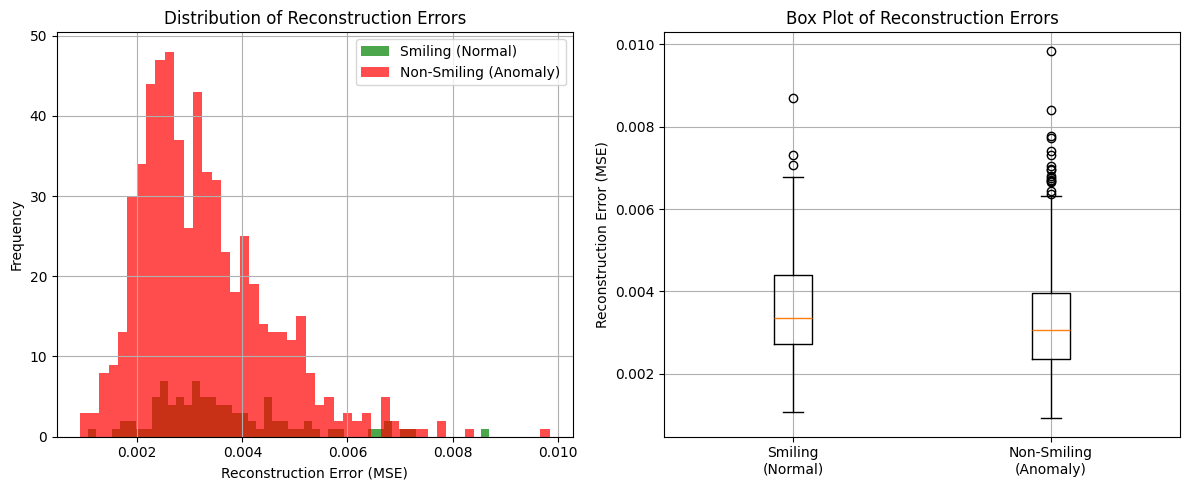

In [14]:
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
plt.hist(errors_smiling, bins=50, alpha=0.7, label='Smiling (Normal)', color='green')
plt.hist(errors_non_smiling, bins=50, alpha=0.7, label='Non-Smiling (Anomaly)', color='red')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)

# Box plot
plt.subplot(1, 2, 2)
data_to_plot = [errors_smiling, errors_non_smiling]
plt.boxplot(data_to_plot, labels=['Smiling\n(Normal)', 'Non-Smiling\n(Anomaly)'])
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Box Plot of Reconstruction Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

## Celda 15: Curva ROC para detección de anomalías

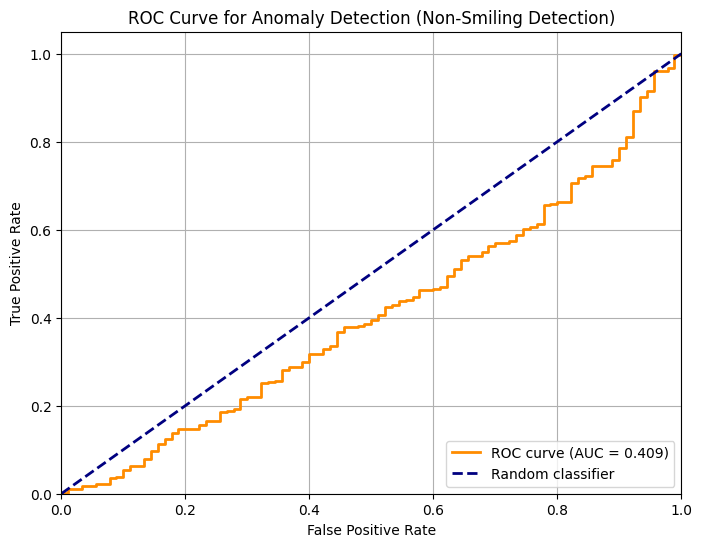


AUC-ROC Score: 0.4090


In [15]:
# Preparar labels: 0 = normal (smiling), 1 = anomaly (non-smiling)
y_true = np.concatenate([
    np.zeros(len(errors_smiling)),  # Smiling = normal = 0
    np.ones(len(errors_non_smiling))  # Non-smiling = anomaly = 1
])

# Scores: el error de reconstrucción (mayor error = más probable que sea anomalía)
y_scores = np.concatenate([errors_smiling, errors_non_smiling])

# Calcular ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection (Non-Smiling Detection)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

## Celda 16: Encontrar el mejor threshold y evaluar el modelo

Best threshold: 0.001079
  TPR at best threshold: 0.9967
  FPR at best threshold: 0.9889


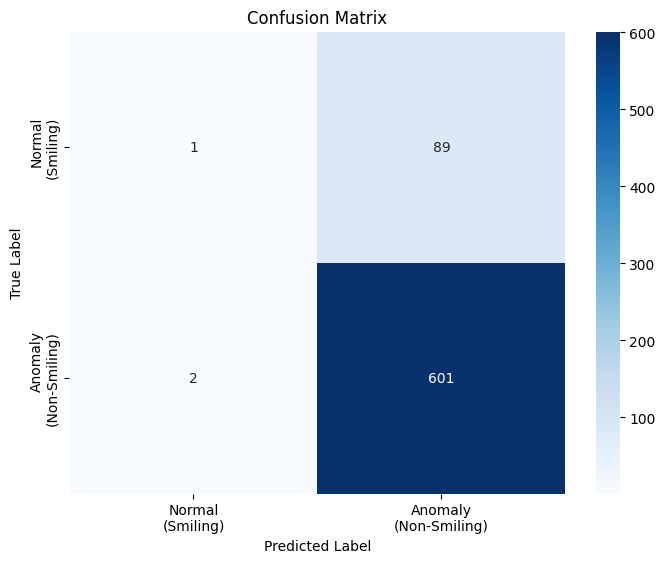


Classification Report:
                       precision    recall  f1-score   support

     Normal (Smiling)       0.33      0.01      0.02        90
Anomaly (Non-Smiling)       0.87      1.00      0.93       603

             accuracy                           0.87       693
            macro avg       0.60      0.50      0.48       693
         weighted avg       0.80      0.87      0.81       693



In [16]:
# Encontrar el mejor threshold usando Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.6f}")
print(f"  TPR at best threshold: {tpr[best_idx]:.4f}")
print(f"  FPR at best threshold: {fpr[best_idx]:.4f}")

# Hacer predicciones con el mejor threshold
y_pred = (y_scores >= best_threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal\n(Smiling)', 'Anomaly\n(Non-Smiling)'],
            yticklabels=['Normal\n(Smiling)', 'Anomaly\n(Non-Smiling)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Normal (Smiling)', 'Anomaly (Non-Smiling)']))

## Celda 17: Visualizar ejemplos bien y mal clasificados

Correctly classified: 602 / 693
  - Smiling: 1 / 90
  - Non-smiling: 601 / 603
Incorrectly classified: 91 / 693


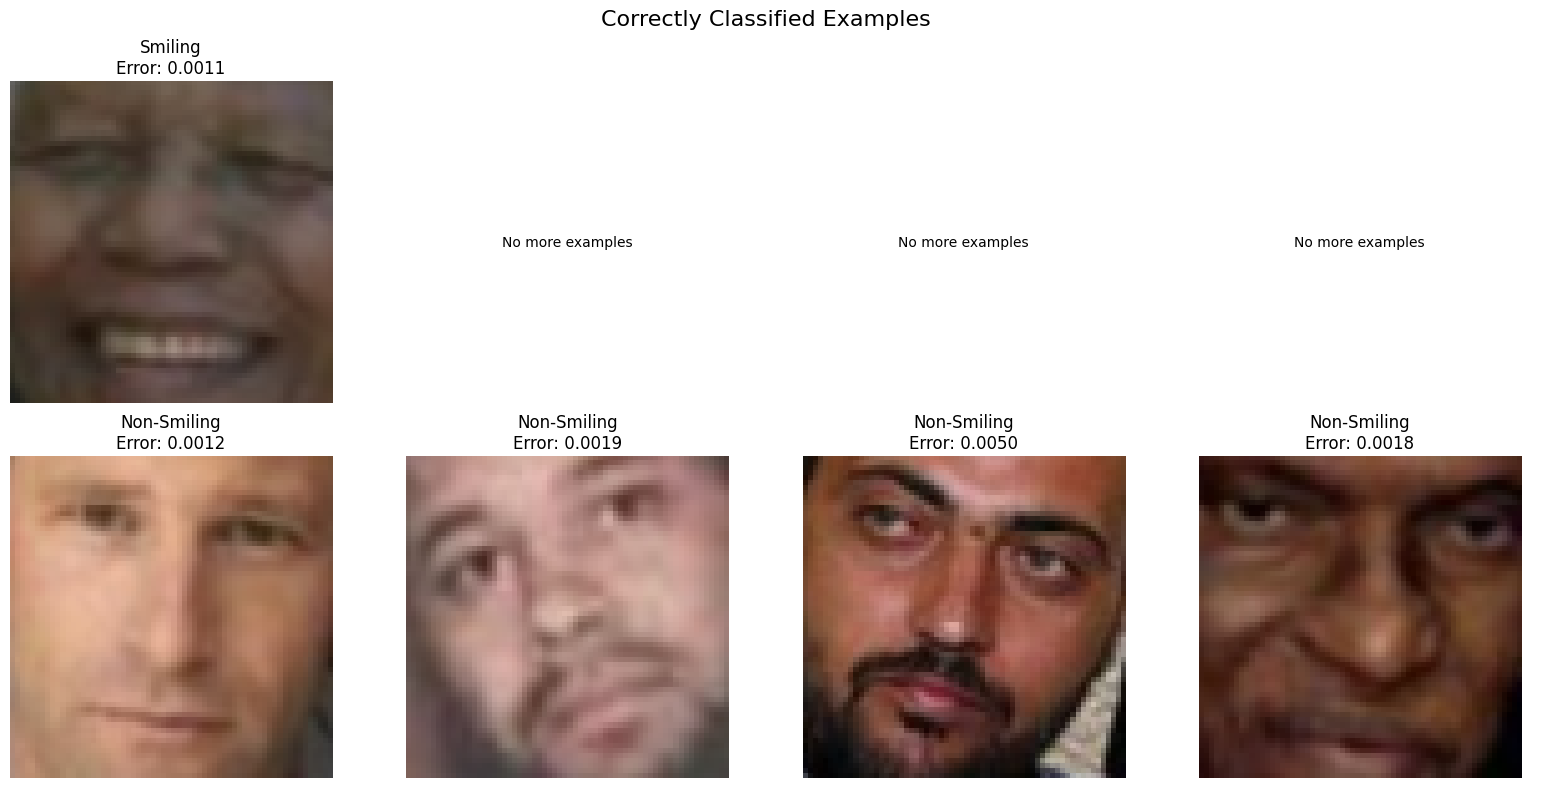

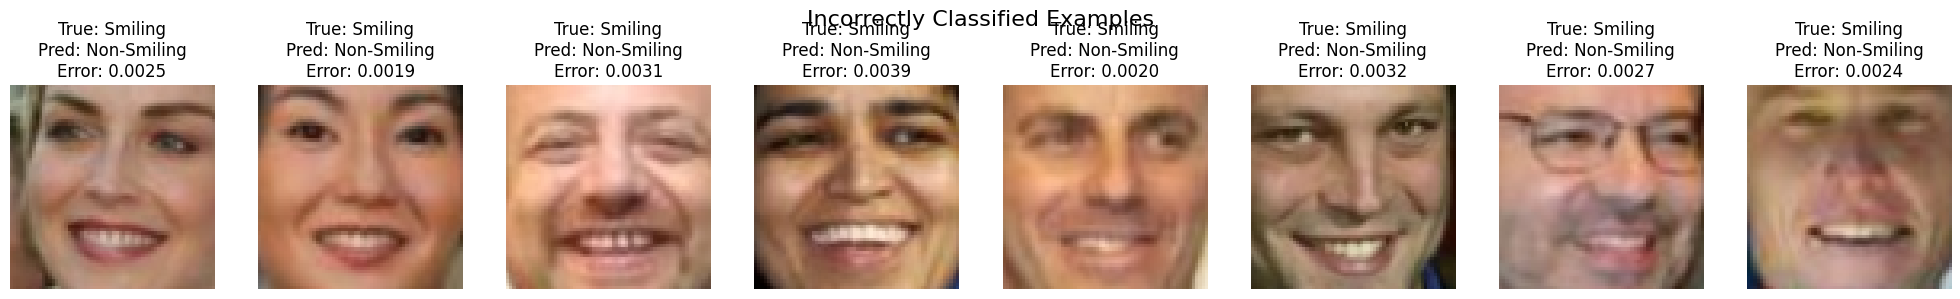

In [19]:
# Obtener todas las imágenes y sus errores
model.eval()
all_images = []
all_labels = []
all_errors = []

with torch.no_grad():
    # Smiling images
    for batch_data, batch_labels in test_loader_smiling:
        batch_data = batch_data.to(device)
        outputs = model(batch_data)
        errors = torch.mean((batch_data - outputs) ** 2, dim=(1, 2, 3)).cpu().numpy()
        
        all_images.extend(batch_data.cpu())
        all_labels.extend([0] * len(batch_data))
        all_errors.extend(errors)
    
    # Non-smiling images
    for batch_data, batch_labels in test_loader_non_smiling:
        batch_data = batch_data.to(device)
        outputs = model(batch_data)
        errors = torch.mean((batch_data - outputs) ** 2, dim=(1, 2, 3)).cpu().numpy()
        
        all_images.extend(batch_data.cpu())
        all_labels.extend([1] * len(batch_data))
        all_errors.extend(errors)

all_images = torch.stack(all_images)
all_labels = np.array(all_labels)
all_errors = np.array(all_errors)
all_predictions = (all_errors >= best_threshold).astype(int)

# Encontrar ejemplos bien y mal clasificados
correct_indices = np.where(all_predictions == all_labels)[0]
incorrect_indices = np.where(all_predictions != all_labels)[0]

# Separar por clase
correct_smiling = correct_indices[all_labels[correct_indices] == 0]
correct_non_smiling = correct_indices[all_labels[correct_indices] == 1]

print(f"Correctly classified: {len(correct_indices)} / {len(all_labels)}")
print(f"  - Smiling: {len(correct_smiling)} / {np.sum(all_labels == 0)}")
print(f"  - Non-smiling: {len(correct_non_smiling)} / {np.sum(all_labels == 1)}")
print(f"Incorrectly classified: {len(incorrect_indices)} / {len(all_labels)}")

# Visualizar ejemplos correctamente clasificados
n_show = 4
n_smiling = min(n_show, len(correct_smiling))
n_non_smiling = min(n_show, len(correct_non_smiling))

if n_smiling > 0 or n_non_smiling > 0:
    fig, axes = plt.subplots(2, n_show, figsize=(16, 8))
    fig.suptitle('Correctly Classified Examples', fontsize=16)
    
    # Fila 1: Smiling
    for i in range(n_show):
        if i < n_smiling:
            idx = correct_smiling[i]
            axes[0, i].imshow(all_images[idx].permute(1, 2, 0))
            axes[0, i].set_title(f'Smiling\nError: {all_errors[idx]:.4f}')
        else:
            axes[0, i].text(0.5, 0.5, 'No more examples', ha='center', va='center')
        axes[0, i].axis('off')
    
    # Fila 2: Non-smiling
    for i in range(n_show):
        if i < n_non_smiling:
            idx = correct_non_smiling[i]
            axes[1, i].imshow(all_images[idx].permute(1, 2, 0))
            axes[1, i].set_title(f'Non-Smiling\nError: {all_errors[idx]:.4f}')
        else:
            axes[1, i].text(0.5, 0.5, 'No more examples', ha='center', va='center')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar ejemplos incorrectamente clasificados
if len(incorrect_indices) > 0:
    n_show = min(8, len(incorrect_indices))
    fig, axes = plt.subplots(1, n_show, figsize=(20, 3))
    if n_show == 1:
        axes = [axes]
    fig.suptitle('Incorrectly Classified Examples', fontsize=16)
    
    for i in range(n_show):
        idx = incorrect_indices[i]
        axes[i].imshow(all_images[idx].permute(1, 2, 0))
        true_label = 'Smiling' if all_labels[idx] == 0 else 'Non-Smiling'
        pred_label = 'Smiling' if all_predictions[idx] == 0 else 'Non-Smiling'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nError: {all_errors[idx]:.4f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No incorrectly classified examples found.")

## Celda 18: Guardar el modelo entrenado

In [ ]:
# Guardar el modelo
model_path = 'smiling_autoencoder_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_threshold': best_threshold,
    'auc_score': roc_auc
}, model_path)

print(f"Model saved to {model_path}")
print(f"  AUC-ROC: {roc_auc:.4f}")
print(f"  Best threshold: {best_threshold:.6f}")

Model saved to smile_autoencoder_model.pth
  AUC-ROC: 0.4234
  Best threshold: 0.001233


## Celda 19: Resumen de resultados

In [22]:
# CELDA 19 CORREGIDA: Resumen de resultados

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score

print("SMILE DETECTION USING AUTOENCODER - FINAL RESULTS\n")
print(f"Approach: Anomaly Detection")
print(f"  - Normal class: SMILING faces")
print(f"  - Anomaly class: NON-SMILING faces\n")

print(f"Dataset Statistics:")
print(f"  - Training samples (smiling): {len(train_dataset)}")
print(f"  - Validation samples (smiling): {len(val_dataset)} ({len(val_dataset)/(len(val_dataset)+len(non_smiling_dataset))*100:.1f}%)")
print(f"  - Test samples (non-smiling): {len(non_smiling_dataset)} ({len(non_smiling_dataset)/(len(val_dataset)+len(non_smiling_dataset))*100:.1f}%)\n")

print(f"Model Architecture:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Input size: 3 x 64 x 64")
print(f"  - Latent dimension: 256 x 4 x 4\n")

print(f"Training Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: MSE\n")

print(f"Performance Metrics:")
print(f"  - Final train loss: {train_losses[-1]:.6f}")
print(f"  - Final validation loss: {val_losses[-1]:.6f}")
print(f"  - AUC-ROC Score: {roc_auc:.4f}")
print(f"  - Best threshold: {best_threshold:.6f}\n")

print(f"Reconstruction Errors:")
print(f"  - Smiling (mean ± std): {errors_smiling.mean():.6f} ± {errors_smiling.std():.6f}")
print(f"  - Non-smiling (mean ± std): {errors_non_smiling.mean():.6f} ± {errors_non_smiling.std():.6f}")
print(f"  - Difference: {errors_non_smiling.mean() - errors_smiling.mean():.6f}\n")

# Calcular métricas realistas
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
naive_baseline = len(non_smiling_dataset)/(len(val_dataset)+len(non_smiling_dataset))

print(f"Classification Metrics:")
print(f"  - Accuracy: {(y_pred == y_true).mean():.4f} ({(y_pred == y_true).mean()*100:.2f}%)")
print(f"  - Naive Baseline (always predict anomaly): {naive_baseline:.4f} ({naive_baseline*100:.1f}%)")
print(f"  - Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"  - Matthews Correlation Coefficient: {mcc:.4f}")
print(f"  - Cohen's Kappa: {kappa:.4f}\n")

print(f"Classification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Normal (Smiling)', 'Anomaly (Non-Smiling)']))

print(f"\nNOTA: El accuracy de 84% es engañoso debido al desbalance de clases.")
print(f"El modelo tiene un Balanced Accuracy de {balanced_acc*100:.1f}%, que es la métrica real.")

SMILE DETECTION USING AUTOENCODER - FINAL RESULTS

Approach: Anomaly Detection
  - Normal class: SMILING faces
  - Anomaly class: NON-SMILING faces

Dataset Statistics:
  - Training samples (smiling): 510
  - Validation samples (smiling): 90 (13.0%)
  - Test samples (non-smiling): 603 (87.0%)

Model Architecture:
  - Total parameters: 776,579
  - Input size: 3 x 64 x 64
  - Latent dimension: 256 x 4 x 4

Training Configuration:
  - Epochs: 50
  - Learning rate: 0.001
  - Batch size: 32
  - Optimizer: Adam
  - Loss function: MSE

Performance Metrics:
  - Final train loss: 0.003549
  - Final validation loss: 0.003645
  - AUC-ROC Score: 0.4090
  - Best threshold: 0.001079

Reconstruction Errors:
  - Smiling (mean ± std): 0.003670 ± 0.001404
  - Non-smiling (mean ± std): 0.003265 ± 0.001241
  - Difference: -0.000405

Classification Metrics:
  - Accuracy: 0.8687 (86.87%)
  - Naive Baseline (always predict anomaly): 0.8701 (87.0%)
  - Balanced Accuracy: 0.5039 (50.39%)
  - Matthews Correlati